# Background

This notebook uses simulated data generated using NICE's R code and demonstrates that the results from this Python implementation of MAIC matches NICE's worked example in R.

Rmarkdown notebooks for data generation and NICE's worked example in R:
- [NICE_DSU_Technical_Support_Document-Appendix_D](../R)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
np.random.seed(42)

# Data Preparation

In [3]:
# Load example simulated data generated by NICE's R code
AB_IPD = pd.read_csv("../data/AB_IPD.csv")
AC_AgD = pd.read_csv("../data/AC_AgD.csv")

In [4]:
N_AB = len(AB_IPD)
print(N_AB)
AB_IPD.sample(5)

500


,ID,age,gender,trt,y
361,112,54,Male,B,0
73,74,63,Female,A,1
374,125,63,Male,B,0
155,156,55,Male,A,1
104,105,68,Female,A,1


In [5]:
AC_AgD

,age.mean,age.sd,N.male,prop.male,y.A.sum,y.A.bar,N.A,y.C.sum,y.C.bar,N.C
0,50.273333,3.124821,68,0.226667,125,0.833333,150,21,0.14,150


# MAIC

In [6]:
def objfn(a1, X):
    return np.sum(np.exp(np.matmul(X, a1)))


def gradfn(a1, X):
    return np.dot(np.exp(np.matmul(X, a1)), X)


X_EM_0 = AB_IPD[["age"]].copy()
X_EM_0["age2"] = X_EM_0["age"] ** 2
X_EM_0["age"] = X_EM_0["age"] - AC_AgD["age.mean"].values[0]
X_EM_0["age2"] = X_EM_0["age2"] - (
    AC_AgD["age.mean"].values[0] ** 2 + AC_AgD["age.sd"].values[0] ** 2
)

In [7]:
# https://machinelearningmastery.com/bfgs-optimization-in-python/
from scipy.optimize import minimize

result = minimize(objfn, (0, 0), method="BFGS", jac=gradfn, args=(X_EM_0))
result

      fun: 196.42069311079803
 hess_inv: array([[ 2.92241711e-01, -2.85979921e-03],
       [-2.85979921e-03,  2.80352467e-05]])
      jac: array([-9.28468431e-08,  2.64740106e-06])
  message: 'Optimization terminated successfully.'
     nfev: 23
      nit: 17
     njev: 23
   status: 0
  success: True
        x: array([ 3.68798616, -0.03696784])

Equivalent results from R worked example:

```
## $par
## [1]  3.68798519 -0.03696784
## 
## $value
## [1] 196.4207
## 
## $counts
## function gradient 
##       68       14 
## 
## $convergence
## [1] 0
## 
## $message
## NULL
```

count    5.000000e+02
mean     1.000000e+00
std      1.343046e+00
min      2.722305e-10
25%      1.968876e-05
50%      3.802917e-02
75%      2.104750e+00
max      3.671091e+00
dtype: float64


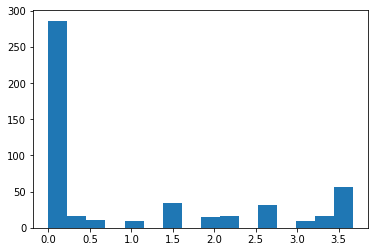

In [8]:
a1 = result.x
wt = np.exp(np.matmul(X_EM_0, a1))
wt_rs = wt / np.sum(wt) * N_AB
print(wt_rs.describe())
plt.hist(wt_rs, bins=16);

Equivalent results from R worked example:

```
##        V1         
##  Min.   :0.00000  
##  1st Qu.:0.00002  
##  Median :0.03803  
##  Mean   :1.00000  
##  3rd Qu.:2.10475  
##  Max.   :3.67109
```

In [9]:
ESS = np.sum(wt) ** 2 / sum(wt ** 2)
ESS

178.56088326014765

Equivalent result from R worked example:

```
## [1] 178.5609
```

In [10]:
age_mean = (AB_IPD["age"] * wt_rs).mean()
age_sd = np.sqrt(np.sum((wt / np.sum(wt)) * (AB_IPD["age"] - age_mean) ** 2))
age_mean, age_sd

(50.273333332860595, 3.1248206289163494)

In [11]:
list(AC_AgD[["age.mean", "age.sd"]].values)

[array([50.27333333,  3.12482062])]

## Binomial GLM

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.sandwich_covariance as sc

AB_IPD["y0"] = 1 - AB_IPD["y"]

mod = smf.glm(
    "y + y0 ~ trt", freq_weights=wt, family=sm.families.Binomial(), data=AB_IPD
).fit(cov_type="HAC", cov_kwds={"maxlags": 0})
mod.summary()

C:\Users\aidan\Anaconda3\envs\indcomp\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1529: SpecificationWarning: cov_type not fully supported with freq_weights
  warnings.warn('cov_type not fully supported with freq_weights',


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            ['y', 'y0']   No. Observations:                  500
Model:                            GLM   Df Residuals:                   194.42
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85.422
Date:                Sat, 08 Jan 2022   Deviance:                       170.84
Time:                        14:37:18   Pearson chi2:                     196.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1831
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9548      0.312      6.261      0.000       1.343       2.567
trt[T.B]      -3.3859      0.401     -8.453      0.000      -4.171      -2.601
==============================================================================
"""

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

AB_IPD["y0"] = 1 - AB_IPD["y"]

mod = smf.glm(
    "y + y0 ~ trt", freq_weights=wt, family=sm.families.Binomial(), data=AB_IPD
).fit(cov_type="HC3")
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            ['y', 'y0']   No. Observations:                  500
Model:                            GLM   Df Residuals:                   194.42
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85.422
Date:                Sat, 08 Jan 2022   Deviance:                       170.84
Time:                        14:37:18   Pearson chi2:                     196.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1831
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9548      0.312      6.261      0.000       1.343       2.567
trt[T.B]      -3.3859      0.401     -8.453      0.000      -4.171      -2.601
==============================================================================
"""

In [14]:
d_AB_MAIC = mod.params["trt[T.B]"]
d_AB_MAIC

-3.385924418590025

Equivalent result from R worked example:

```
##      trtB 
## -3.385924
```

In [15]:
# import statsmodels.stats.sandwich_covariance as sc
# var_d_AB_MAIC = sc.cov_hac(mod)[1][1]

var_d_AB_MAIC = mod.cov_params_default[1][1]

Equivalent result from R worked example: [DOES NOT MATCH]

```
## [1] 0.170214
```

In [16]:
d_AC = np.log(
    AC_AgD["y.C.sum"]
    * (AC_AgD["N.A"] - AC_AgD["y.A.sum"])
    / (AC_AgD["y.A.sum"] * (AC_AgD["N.C"] - AC_AgD["y.C.sum"]))
)
var_d_AC = (
    1 / AC_AgD["y.A.sum"]
    + 1 / (AC_AgD["N.A"] - AC_AgD["y.A.sum"])
    + 1 / AC_AgD["y.C.sum"]
    + 1 / (AC_AgD["N.C"] - AC_AgD["y.C.sum"])
)
d_B_MAIC = d_AC - d_AB_MAIC
d_B_MAIC

0   -0.038803
dtype: float64

Equivalent result from R worked example:

```
##        trtB 
## -0.03880351
```

In [17]:
var_d_BC_MAIC = var_d_AC + var_d_AB_MAIC
var_d_BC_MAIC

0    0.263819
dtype: float64

Equivalent result from R worked example: [DOES NOT MATCH DUE TO `var_d_AB_MAIC`]

```
## [1] 0.273585
```